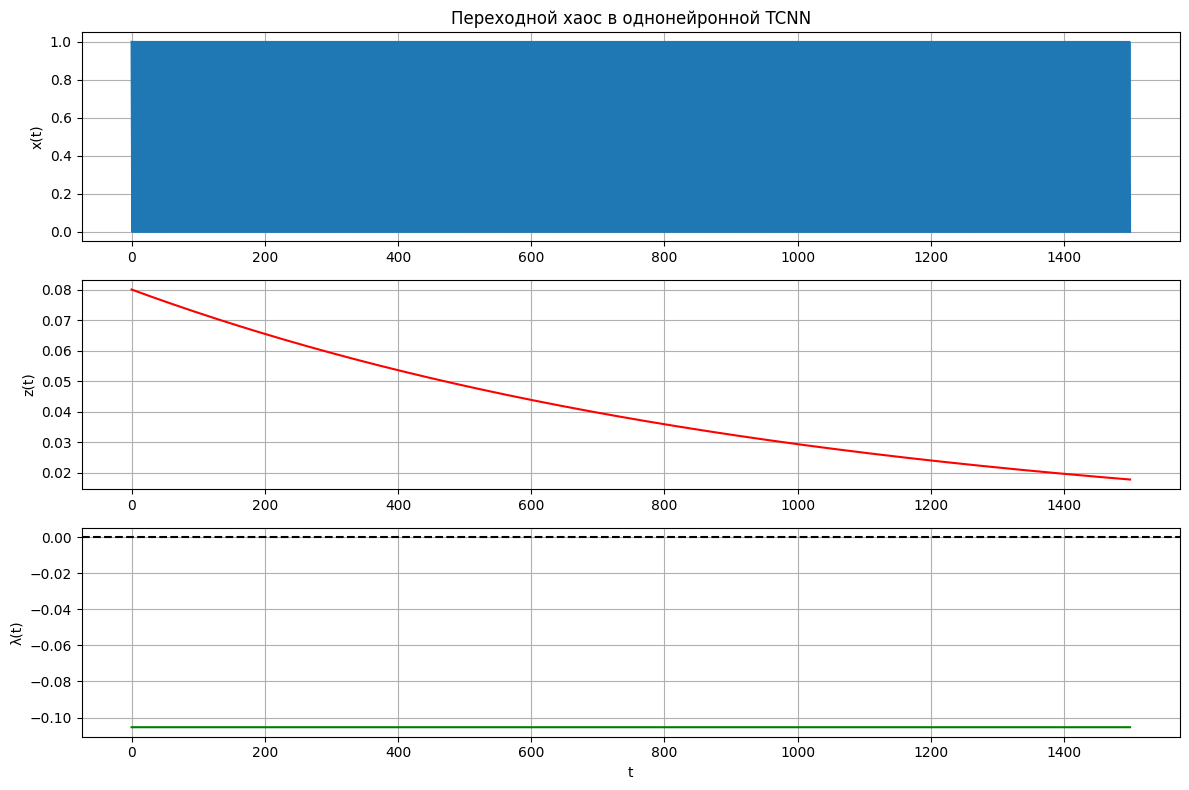

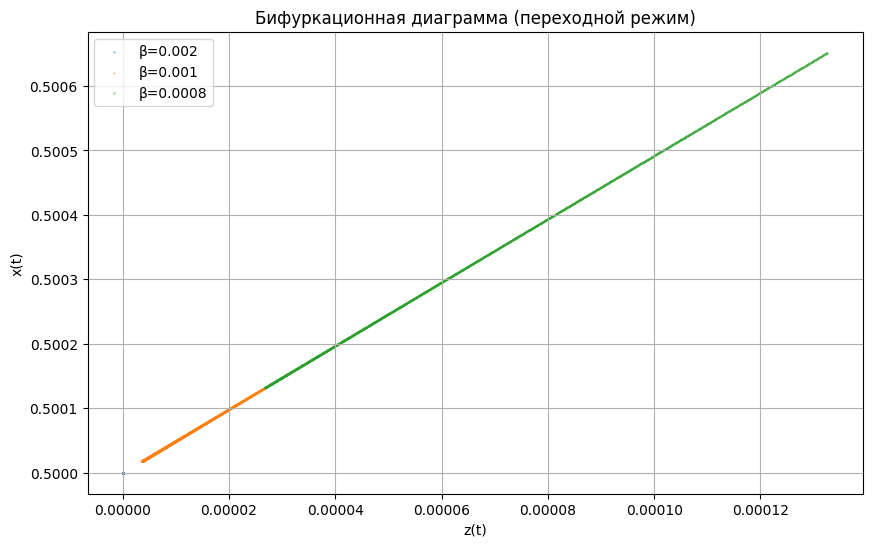

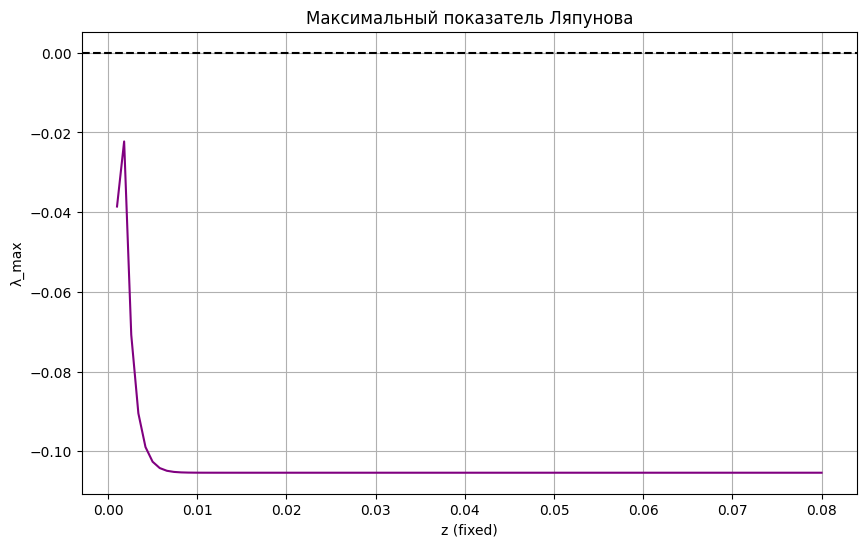

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Однонейронная TCNN
# -------------------------------
def single_neuron_tcnn(y0, k, c, I0, z0, beta, gamma, num_steps):
    """
    Однонейронная TCNN с экспоненциально затухающей рефрактерностью z(t)
    """
    y_vals = np.zeros(num_steps)
    x_vals = np.zeros(num_steps)
    z_vals = np.zeros(num_steps)

    y = y0
    z = z0

    for t in range(num_steps):
        x = 1.0 / (1.0 + np.exp(-y / c))

        y_new = k * y + gamma - z * (x - I0)
        z_new = (1.0 - beta) * z

        y_vals[t] = y
        x_vals[t] = x
        z_vals[t] = z

        y = y_new
        z = z_new

    return y_vals, x_vals, z_vals


# -------------------------------
# Корректный λ_max при фиксированном z
# -------------------------------
def calculate_lyapunov_exponent_fixed_z(k, c, I0, gamma, z_fixed, y0, num_iterations):
    """
    Корректная оценка максимального показателя Ляпунова
    для отображения:
        y_{t+1} = k y_t + gamma - z (f(y_t) - I0)
    """
    y = y0
    lyap_sum = 0.0

    for _ in range(num_iterations):
        # f(y)
        exp_term = np.exp(-y / c)
        x = 1.0 / (1.0 + exp_term)

        # f'(y)
        fp = (1.0 / c) * exp_term / (1.0 + exp_term)**2

        # Производная отображения
        deriv = k - z_fixed * fp

        lyap_sum += np.log(abs(deriv))

        # Следующий шаг
        y = k * y + gamma - z_fixed * (x - I0)

    return lyap_sum / num_iterations


# -------------------------------
# ПАРАМЕТРЫ (канонические)
# -------------------------------
k = -0.9
c_val = 1.0 / 250.0
I0 = 0.65
z0 = 0.08
beta = 0.001
gamma = 0.0
y0 = 0.5

num_steps = 10000


# ==========================================================
# 1. Переходной хаос: временные ряды + λ(t)
# ==========================================================
y_vals, x_vals, z_vals = single_neuron_tcnn(
    y0, k, c_val, I0, z0, beta, gamma, num_steps
)

# Running Lyapunov exponent (переходной)
lyap_vals = np.zeros(num_steps)
lyap_sum = 0.0

for t in range(num_steps):
    y = y_vals[t]
    z = z_vals[t]

    exp_term = np.exp(-y / c_val)
    fp = (1.0 / c_val) * exp_term / (1.0 + exp_term)**2
    deriv = k - z * fp

    lyap_sum += np.log(abs(deriv))
    lyap_vals[t] = lyap_sum / (t + 1)


plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(x_vals[:1500])
plt.ylabel("x(t)")
plt.title("Переходной хаос в однонейронной TCNN")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(z_vals[:1500], color="red")
plt.ylabel("z(t)")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(lyap_vals[:1500], color="green")
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("λ(t)")
plt.xlabel("t")
plt.grid(True)

plt.tight_layout()
plt.show()


# ==========================================================
# 2. Бифуркационная диаграмма (x vs z)
# ==========================================================
plt.figure(figsize=(10, 6))

for beta_val in [0.002, 0.001, 0.0008]:
    y_vals, x_vals, z_vals = single_neuron_tcnn(
        y0, k, c_val, I0, z0, beta_val, gamma, num_steps
    )
    plt.scatter(z_vals[-2000:], x_vals[-2000:], s=0.1, label=f"β={beta_val}")

plt.xlabel("z(t)")
plt.ylabel("x(t)")
plt.title("Бифуркационная диаграмма (переходной режим)")
plt.legend()
plt.grid(True)
plt.show()


# ==========================================================
# 3. λ_max при фиксированном z
# ==========================================================
z_range = np.linspace(0.001, z0, 100)
lyapunov_estimates = []

for z_fixed in z_range:
    lyap = calculate_lyapunov_exponent_fixed_z(
        k, c_val, I0, gamma, z_fixed, y0, 10000
    )
    lyapunov_estimates.append(lyap)

plt.figure(figsize=(10, 6))
plt.plot(z_range, lyapunov_estimates, color="purple")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("z (fixed)")
plt.ylabel("λ_max")
plt.title("Максимальный показатель Ляпунова")
plt.grid(True)
plt.show()
